**Comparision with different embedding size ( 64,128 and 512)**

### Euclidean Distance – Embedding Size vs Accuracy & Loss

| **Embedding Size** | **Val Accuracy** | **Val Loss** | **observation**                          |
|--------------------|------------------|--------------|--------------------------------------|
| 64           | 0.4785           | 1.8241       | Lowest accuracy, is probably underfitting        |
| **128**            | **0.5015**      | **1.7754**       | **Best accuracy and lowest loss**       |
| 512           | 0.4901           | 1.8189       | Slight improvement over 64, but is unstable |


From 64 to 128 size the model shows improvement in accuracy and loss
But from 128 to 512, the accuracy drops due to overfitting.


### Squared Euclidean Distance – Embedding Size vs Accuracy & Loss

| **Embedding Size** | **Val Accuracy** | **Val Loss** | **Observation**                            |
|--------------------|------------------|--------------|----------------------------------------|
| 64             | 0.3951           | 6.4476       |  Underfitting  |
| **128**            | **0.5005**         | **1.7778**      | **Best accuracy and loss**               |
| 512            | 0.4905           | 1.8220       | Slight overfitting, unstable in high-dim |

In Squared Euclidean diatance there was a major jump from 6.4476 val loss to 1.7778 indicating increase in accuracy and generalisation
but from 128 to 512 there seem to be slight overfitting and also instability.


Overall, the results clearly indicate that an embedding size of 128 yields the best performance across both Euclidean and squared Euclidean distance metrics.




References

### For distance implementation referred PyTorch official documentation (for tensor operations: torch.sum, torch.abs, etc.)

In [ ]:
from time import perf_counter
from typing import Tuple, Dict, Optional, Callable

import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, RandomCrop, RandomHorizontalFlip, Compose, CenterCrop, RandomAffine, ColorJitter

from boilerplate import get_accuracy
from boilerplate import count_parameters, plot_learning_curves, EarlyStopping

## Loading Data

This first part just serves to get the actual CIFAR100 data. We then *combine* the training and test sets, since we actually want to split the data *by class*.

There are also some data augmentation transforms defined here; to be quite honest this is just because I was lazily copy-pasting from previous assignments. But these transforms are then later used when training the actual Prototypical Networks, as well.

In [ ]:
train_transforms = []
test_transforms = []

flip = True
rotation = 15
scale = (0.8, 1.2)
color = (0.95, 1.05)
translation = 0.1

if color is not None:
    train_transforms.append(ColorJitter(color, color, color, (color[0]-1, color[1]-1)))  # brightness, contrast, saturation, hue
if rotation > 0 or scale is not None:
    train_transforms.append(RandomAffine(degrees=rotation,
                                         translate=(translation, translation),
                                         scale=scale))
if flip:
    train_transforms.append(RandomHorizontalFlip())

train_transforms.append(ToTensor())
test_transforms.append(ToTensor())

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=Compose(train_transforms))

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=Compose(test_transforms))

100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


In [ ]:
all_images = np.concatenate((train_data.data, test_data.data), axis=0)
all_targets = np.concatenate((train_data.targets, test_data.targets), axis=0)

## Splitting By Class

CIFAR100 has 100 classes which are summarized in 20 "superclasses". I decided to split into training/validation/test by those superclasses -- for each superclass, three classes go into training, and one each into validation/test. I thought this might make it easier, since the model has at least seen each "superclass" evenly. The "problem" is that this forces us into a 60/20/20 split, which is relatively little training data, just 36000 points.

Also note that performance may depend heavily on which classes end up in training/test sets -- some classes may be easier to generalize to than others. As such, a detailed evaluation of our models would involve different splits. You can change the `seed` of the permutation further below to change the split.

In [ ]:
# I just copied this from the CIFAR100 website.
# I stated putting quotation marks and brackets [] around stuff, then I got sick of it.
"""
{"aquatic mammals": 	[beaver, dolphin, otter, seal, whale],
"fish": 	[aquarium fish, flatfish, ray, shark, trout],
"flowers": 	[orchids, poppies, roses, sunflowers, tulips],
"food containers": 	[bottles, bowls, cans, cups, plates],
"fruit and vegetables": 	[apples, mushrooms, oranges, pears, sweet peppers],
"household electrical devices": 	[clock, computer keyboard, lamp, telephone, television],
"household furniture": 	[bed, chair, couch, table, wardrobe],
"insects": 	[bee, beetle, butterfly, caterpillar, cockroach],
"large carnivores": 	[bear, leopard, lion, tiger, wolf],
"large man-made outdoor things": 	[bridge, castle, house, road, skyscraper],
"large natural outdoor scenes": 	[cloud, forest, mountain, plain, sea],
"large omnivores and herbivores": 	[camel, cattle, chimpanzee, elephant, kangaroo],
"medium-sized mammals": 	[fox, porcupine, possum, raccoon, skunk],
"non-insect invertebrates": 	[crab, lobster, snail, spider, worm],
"people": 	[baby, boy, girl, man, woman],
"reptiles": 	[crocodile, dinosaur, lizard, snake, turtle],
"small mammals": 	[hamster, mouse, rabbit, shrew, squirrel],
"trees": 	[maple, oak, palm, pine, willow],
"vehicles 1": 	[bicycle, bus, motorcycle, pickup truck, train],
"vehicles 2": 	[lawn-mower, rocket, streetcar, tank, tractor]}
"""

'\n{"aquatic mammals": \t[beaver, dolphin, otter, seal, whale],\n"fish": \t[aquarium fish, flatfish, ray, shark, trout],\n"flowers": \t[orchids, poppies, roses, sunflowers, tulips],\n"food containers": \t[bottles, bowls, cans, cups, plates],\n"fruit and vegetables": \t[apples, mushrooms, oranges, pears, sweet peppers],\n"household electrical devices": \t[clock, computer keyboard, lamp, telephone, television],\n"household furniture": \t[bed, chair, couch, table, wardrobe],\n"insects": \t[bee, beetle, butterfly, caterpillar, cockroach],\n"large carnivores": \t[bear, leopard, lion, tiger, wolf],\n"large man-made outdoor things": \t[bridge, castle, house, road, skyscraper],\n"large natural outdoor scenes": \t[cloud, forest, mountain, plain, sea],\n"large omnivores and herbivores": \t[camel, cattle, chimpanzee, elephant, kangaroo],\n"medium-sized mammals": \t[fox, porcupine, possum, raccoon, skunk],\n"non-insect invertebrates": \t[crab, lobster, snail, spider, worm],\n"people": \t[baby, boy

In [ ]:
# I USED CHATGPT TO PUT QUOTATION MARKS AROUND THE WORDS OK?!
# and then I had to rename some of the classes to fit with the torchvision CIFAR100 class

superclasses = {
  "aquatic mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
  "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
  "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
  "food containers": ["bottle", "bowl", "can", "cup", "plate"],
  "fruit and vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
  "household electrical devices": ["clock", "keyboard", "lamp", "telephone", "television"],
  "household furniture": ["bed", "chair", "couch", "table", "wardrobe"],
  "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
  "large carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
  "large man-made outdoor things": ["bridge", "castle", "house", "road", "skyscraper"],
  "large natural outdoor scenes": ["cloud", "forest", "mountain", "plain", "sea"],
  "large omnivores and herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
  "medium-sized mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
  "non-insect invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
  "people": ["baby", "boy", "girl", "man", "woman"],
  "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
  "small mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
  "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
  "vehicles 1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
  "vehicles 2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}

In [ ]:
superclasses_keys = list(superclasses.keys())
superclasses_keys

['aquatic mammals',
 'fish',
 'flowers',
 'food containers',
 'fruit and vegetables',
 'household electrical devices',
 'household furniture',
 'insects',
 'large carnivores',
 'large man-made outdoor things',
 'large natural outdoor scenes',
 'large omnivores and herbivores',
 'medium-sized mammals',
 'non-insect invertebrates',
 'people',
 'reptiles',
 'small mammals',
 'trees',
 'vehicles 1',
 'vehicles 2']

In [ ]:
superclasses_index_map = []
for supclass in superclasses_keys:  # iterate over list to guarantee ordering
    classes = superclasses[supclass]
    classes_ind = [train_data.class_to_idx[subclass] for subclass in classes]
    superclasses_index_map.append(classes_ind)
superclasses_index_map = np.array(superclasses_index_map)
superclasses_index_map

array([[ 4, 30, 55, 72, 95],
       [ 1, 32, 67, 73, 91],
       [54, 62, 70, 82, 92],
       [ 9, 10, 16, 28, 61],
       [ 0, 51, 53, 57, 83],
       [22, 39, 40, 86, 87],
       [ 5, 20, 25, 84, 94],
       [ 6,  7, 14, 18, 24],
       [ 3, 42, 43, 88, 97],
       [12, 17, 37, 68, 76],
       [23, 33, 49, 60, 71],
       [15, 19, 21, 31, 38],
       [34, 63, 64, 66, 75],
       [26, 45, 77, 79, 99],
       [ 2, 11, 35, 46, 98],
       [27, 29, 44, 78, 93],
       [36, 50, 65, 74, 80],
       [47, 52, 56, 59, 96],
       [ 8, 13, 48, 58, 90],
       [41, 69, 81, 85, 89]])

In [ ]:
# for each superclass, we choose one class each for validation and test sets;
# the other three go into training
n_superclasses = superclasses_index_map.shape[0]
superclass_indices_train = np.zeros((n_superclasses, 3), dtype=np.int32)
superclass_indices_valid = np.zeros((n_superclasses, 1), dtype=np.int32)
superclass_indices_test = np.zeros((n_superclasses, 1), dtype=np.int32)

# change this seed to change the split!
seed = 12
rng = np.random.default_rng(seed)
for ind_spc, classes in enumerate(superclasses_index_map):
    permute = rng.permutation(classes)
    superclass_indices_train[ind_spc] = permute[:3]
    superclass_indices_valid[ind_spc] = permute[3]
    superclass_indices_test[ind_spc] = permute[4]
    print(permute)

[30 55 72 95  4]
[32 91 73  1 67]
[92 62 82 70 54]
[10 16 61 28  9]
[51 83 57 53  0]
[22 39 40 86 87]
[20 25 84 94  5]
[24 18  6 14  7]
[ 3 97 88 43 42]
[12 68 37 17 76]
[23 49 71 60 33]
[21 38 31 19 15]
[66 64 34 75 63]
[45 26 99 77 79]
[46 98 11  2 35]
[78 29 93 27 44]
[36 74 65 80 50]
[56 52 59 96 47]
[90 58 13 48  8]
[89 81 85 41 69]


In [ ]:
superclass_indices_test

array([[ 4],
       [67],
       [54],
       [ 9],
       [ 0],
       [87],
       [ 5],
       [ 7],
       [42],
       [76],
       [33],
       [15],
       [63],
       [79],
       [35],
       [44],
       [50],
       [47],
       [ 8],
       [69]], dtype=int32)

Now we write our own dataset. An important component here is a map `class_indices` that gives, for each class, the indices in the dataset belonging to this class. This will later allow us to sample elements specifically for previously chosen classes. This differs from our usual fully random sampling. Note that, mainly due to laziness, each dataset receives _all_ images. But we will later take care to only sample from the respective subset.

In [ ]:
class ProtoCIFAR100(Dataset):
    def __init__(self,
                 images: np.ndarray,
                 targets: np.ndarray,
                 super_to_sub_map: np.ndarray,
                 transform: Optional = None):
        super().__init__()
        self.transform = transform
        self.data = images
        self.targets = targets

        self.super_to_sub_map = super_to_sub_map
        self.classes_flat = super_to_sub_map.reshape(-1)

        self.class_indices = {}
        for index in self.classes_flat:
            self.class_indices[index] = torch.tensor(np.where(self.targets == index)[0])

        _, self.class_counts = np.unique(targets, return_counts=True)

    def __getitem__(self,
                    index: int):
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        total_count = 0
        for _class in self.classes_flat:
            total_count += self.class_counts[_class]
        return total_count

In [ ]:
train_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_train, transform=Compose(train_transforms))
valid_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_valid, transform=Compose(test_transforms))
test_data = ProtoCIFAR100(all_images, all_targets, superclass_indices_test, transform=Compose(test_transforms))

Finally, we write a custom `Sampler` that is then used by the `DataLoader`. This class is responsible for supplying indices, which the dataloader then uses to actually index into the data.

To keep things simple, we use sampling "with replacement". That is, for each batch, we randomly sample some data, with no regard for "iterating" over the dataset as we usually would do. This means that there is no real concept of epochs, and we may sample some elements from the dataset more often than others. Statistically, in the long run, this is still the same as a "clean" iteration over the data. It is, however, much easier to implement in our case. The main thing that would make iteration hard is that we only sample a subset of classes at each step to keep batch size in control. Handling this in a way that all classes are sampled equally often would be quite complicated.

Basically our sampler
- Chooses a random subset of classes from the dataset.
- For each class, samples `n_support + n_query` elements from the data.
- The above process is one batch; we arbitrarily define an epoch as a pre-defined number of batches.

The resulting batch is returned in just one dimension, i.e. the "batch size" is `num_classes_sampled * n_support * n_query`. Of course we later need to split this batch into the different classes as well as support and query sets; this is handled in the training step function which simply assumes the incoming data follows the format that is constructed in this sampler. This whole thing is a bit brittle, but easier to implement this way, as we can use the standard `DataLoader` class. An alternative would be to use our own dataloader, or at least `collate_fn` (remember the IMDB assignment), to split the data into the respective subsets and give the data to the training step already in the correct format.

In [ ]:
class SubclassBatchSampler(Sampler):
    def __init__(self,
                 datasource: Dataset,
                 n_support: int,
                 n_query: int,
                 classes_per_batch: int,
                 batches_per_epoch: int):
        self.datasource = datasource
        self.n_support = n_support
        self.n_query = n_query
        self.classes_per_batch = classes_per_batch
        self.batches_per_epoch = batches_per_epoch

    def __iter__(self):
        available_classes = self.datasource.classes_flat
        n_classes = len(available_classes)
        if self.classes_per_batch is None or self.classes_per_batch == n_classes:
            sample_classes = False
        else:
            sample_classes = True

        for batch_ind in range(self.batches_per_epoch):
            if sample_classes:
                chosen_class_indices = torch.randperm(n_classes)[:self.classes_per_batch]
                chosen_classes = available_classes[chosen_class_indices]
            else:
                chosen_classes = available_classes

            dataset_indices = []
            for _class in chosen_classes:
                n_samples_for_class = self.datasource.class_counts[_class]
                class_indices = torch.randperm(n_samples_for_class)[:self.n_support + self.n_query]
                dataset_indices.append(self.datasource.class_indices[_class.item()][class_indices])

            yield torch.cat(dataset_indices)

    def __len__(self):
        return self.batches_per_epoch

In [ ]:
n_support = 5
n_query = 10
classes_per_batch = 20
batches_per_epoch = 200


train_sampler = SubclassBatchSampler(train_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                     batches_per_epoch=batches_per_epoch)
valid_sampler = SubclassBatchSampler(valid_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                     batches_per_epoch=batches_per_epoch)
test_sampler = SubclassBatchSampler(test_data, n_support=n_support, n_query=n_query, classes_per_batch=classes_per_batch,
                                    batches_per_epoch=batches_per_epoch)

Here we print one batch of our sampler. Observe how we get classes in sequence, i.e. all samples are of one class, then it switches ot another class, etc. If you were to count, you would see that there are `n_support + n_query` samples per class, and `classes_per_batch` classes in total. You can play with these numbers if you want.

In particular, if you later find training time to be intolerably high, you could reduce `n_query` and/or `classes_per_batch`. You could also reduce `n_support`, but this fundamentally changes the learning problem -- for example, in the extreme, `n_support = 1` corresponds to so-called one-shot learning.

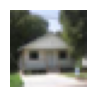

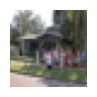

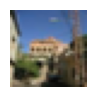

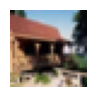

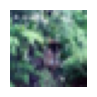

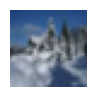

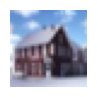

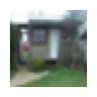

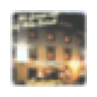

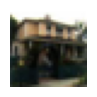

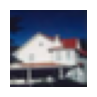

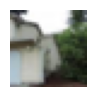

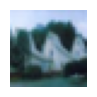

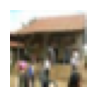

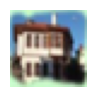

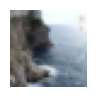

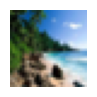

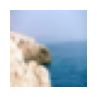

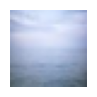

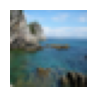

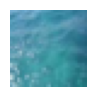

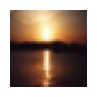

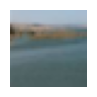

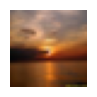

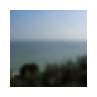

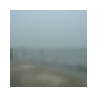

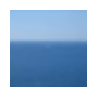

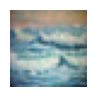

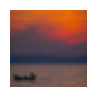

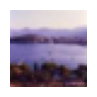

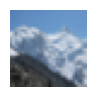

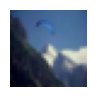

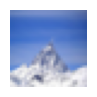

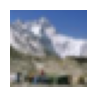

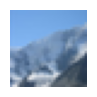

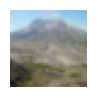

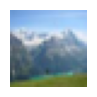

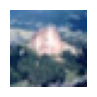

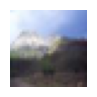

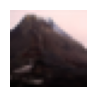

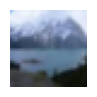

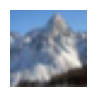

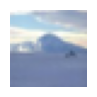

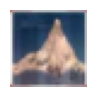

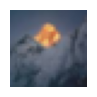

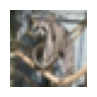

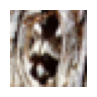

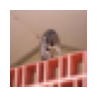

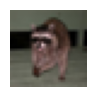

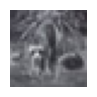

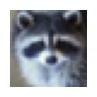

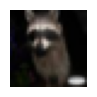

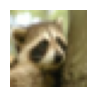

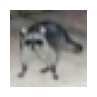

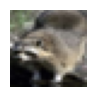

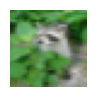

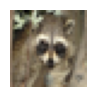

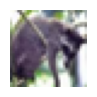

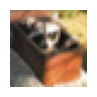

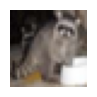

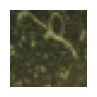

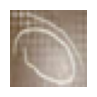

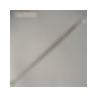

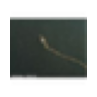

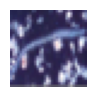

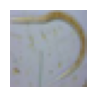

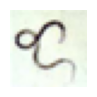

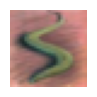

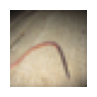

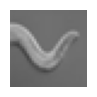

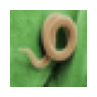

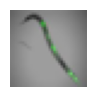

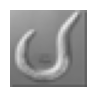

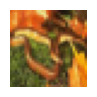

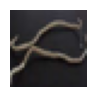

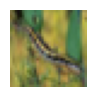

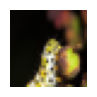

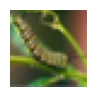

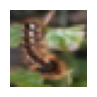

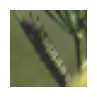

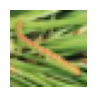

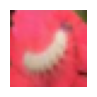

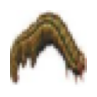

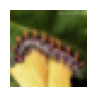

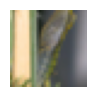

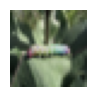

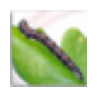

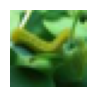

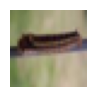

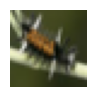

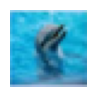

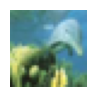

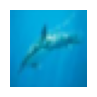

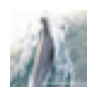

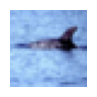

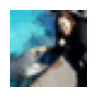

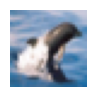

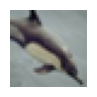

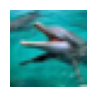

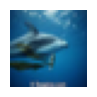

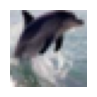

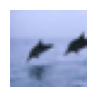

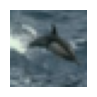

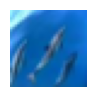

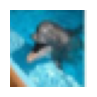

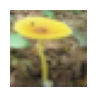

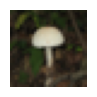

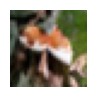

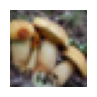

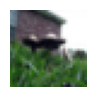

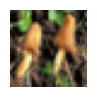

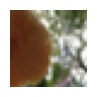

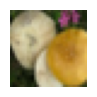

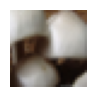

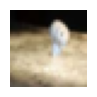

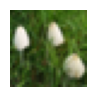

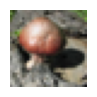

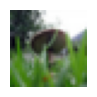

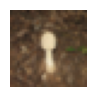

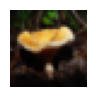

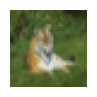

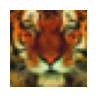

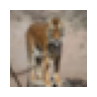

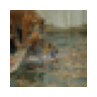

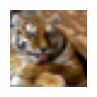

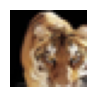

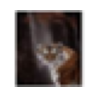

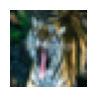

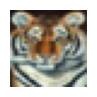

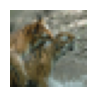

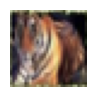

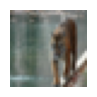

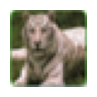

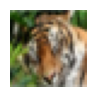

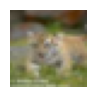

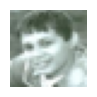

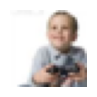

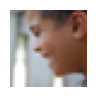

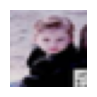

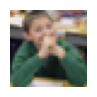

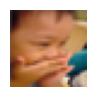

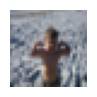

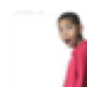

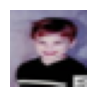

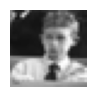

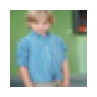

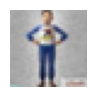

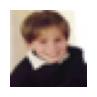

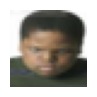

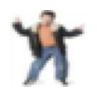

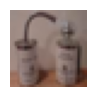

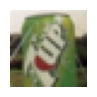

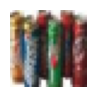

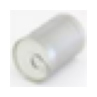

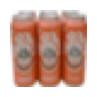

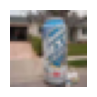

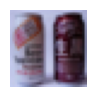

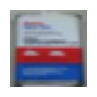

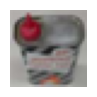

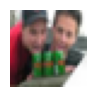

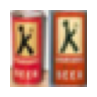

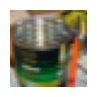

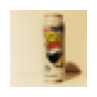

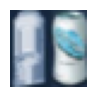

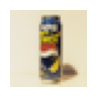

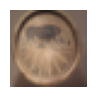

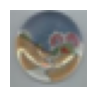

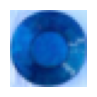

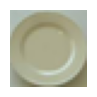

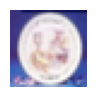

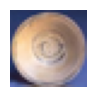

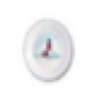

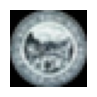

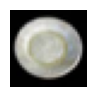

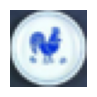

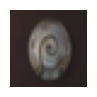

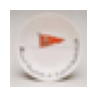

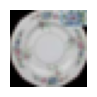

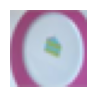

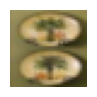

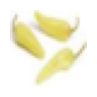

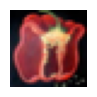

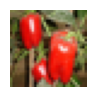

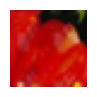

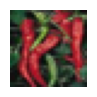

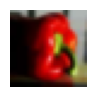

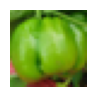

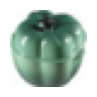

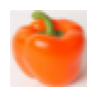

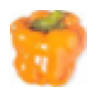

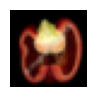

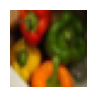

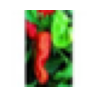

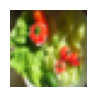

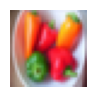

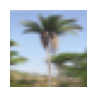

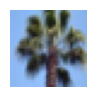

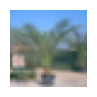

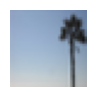

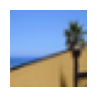

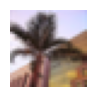

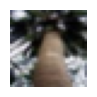

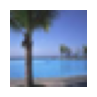

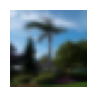

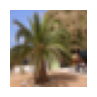

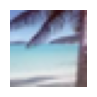

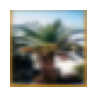

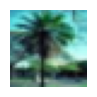

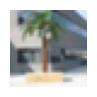

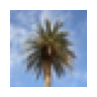

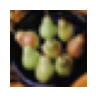

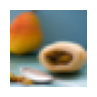

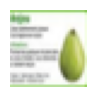

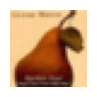

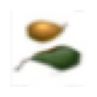

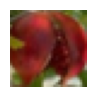

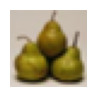

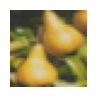

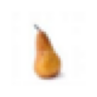

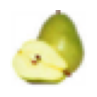

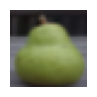

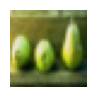

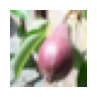

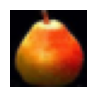

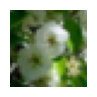

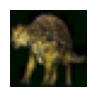

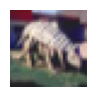

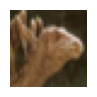

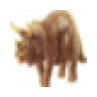

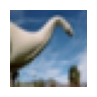

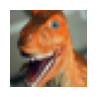

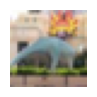

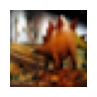

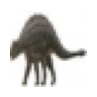

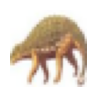

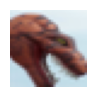

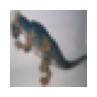

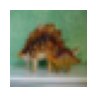

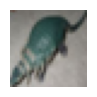

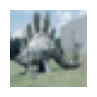

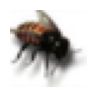

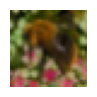

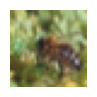

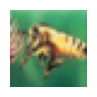

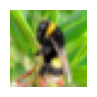

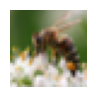

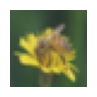

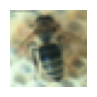

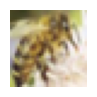

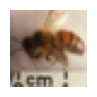

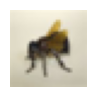

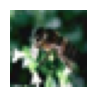

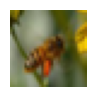

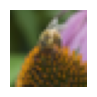

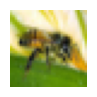

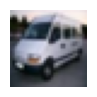

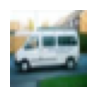

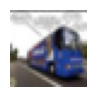

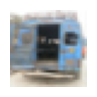

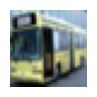

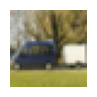

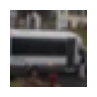

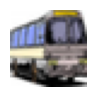

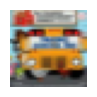

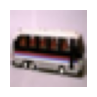

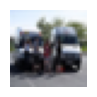

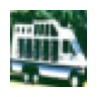

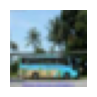

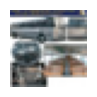

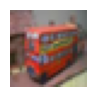

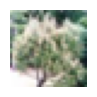

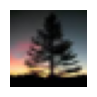

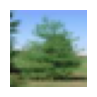

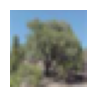

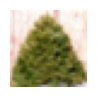

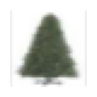

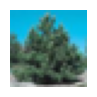

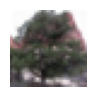

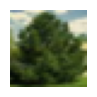

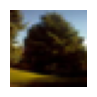

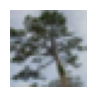

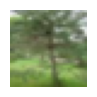

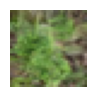

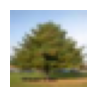

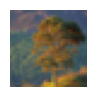

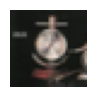

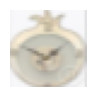

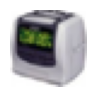

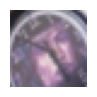

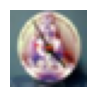

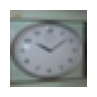

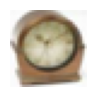

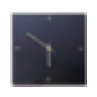

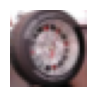

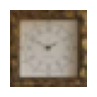

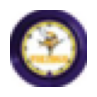

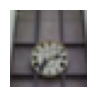

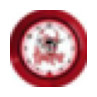

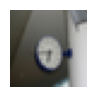

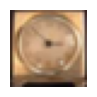

In [ ]:
for thing in train_sampler:
    #print(thing)
    for ind in thing:
        plt.figure(figsize=(1,1))
        plt.axis("off")
        plt.imshow(train_data.data[ind])
        plt.show()
    break

As usual, you may have to reduce `num_workers` depending on your machine!

In [ ]:
train_dataloader = DataLoader(train_data, batch_sampler=train_sampler, pin_memory=True,
                              num_workers=16)
valid_dataloader = DataLoader(valid_data, batch_sampler=valid_sampler, pin_memory=True,
                              num_workers=16)
test_dataloader = DataLoader(test_data, batch_sampler=test_sampler, pin_memory=True,
                             num_workers=16)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([300, 3, 32, 32])
Shape of y: torch.Size([300]) torch.int64


In [ ]:
len(train_sampler)

200

## Model

We can build any model that takes in a CIFAR100 image and returns a vector. So you can use any of our previously used CNN architectures. It just has to result in a vector output. Do not include the typical classificaton layer at the end!

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

embed_dim = 512

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten()
)
model.append(nn.LazyLinear(embed_dim))

# run model to initialize lazy layers
model = model.to(device)
with torch.no_grad():
    test = model(next(iter(train_dataloader))[0].to(device))
print(model)
print(test.shape)

Using cuda device
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=512, bias=True)
)
torch.Size([300, 512])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_params = count_parameters(model)
print("Model with {} trainable parameters".format(num_params))

Model with 548384 trainable parameters


In [ ]:
# the usual....
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

This is our core logic for training and evaluating. There are a few steps left to fill in. The distance functions are relatively time-efficient, but rather space-inefficient, methods to compute the distance between all prototypes and all queries at once. It relies on _broadcasting_ to replicate the protoypes over the query axis, and the queries over the prototype axis. You should be able to apply this principle to also compute other functions besides euclidean distance!

Aside from that, the `prototype_step` handles the main logic of splitting the batch into support and query sets, and split into the different classes, as well as computing embeddings, distances, and logits for classification.

In [ ]:
def euclidean_distance(prototypes, queries):
    return torch.sqrt(torch.square(prototypes[:, torch.newaxis, :] - queries[torch.newaxis, :, :]).sum(dim=-1))

# For distance implementation referred PyTorch official documentation (for tensor operations: torch.sum, torch.abs, etc.)
def squared_euclidean_distance(prototypes, queries):
    return torch.sum((prototypes[:, None, :] - queries[None, :, :]) ** 2, dim=-1)


def abs_distance(prototypes, queries):
     return torch.sum(torch.abs(prototypes[:, None, :] - queries[None, :, :]), dim=-1)


def dot_distance(prototypes, queries):
     return -torch.matmul(prototypes, queries.T)


def prototype_step(image_batch: torch.Tensor,
                   model: nn.Module,
                   n_support: int,
                   n_query: int,
                   distance_fn: Callable):
    # down below:
    # n_per_class is n_support + n_query
    # b is n_classes * n_query (i.e. total query batch size)

    # image_batch is the whole "episode" -- support and query for all classes

    embeddings = model(image_batch)  # batch x features
    per_class = embeddings.view(-1, n_support + n_query, embeddings.shape[-1])  # classes x (n_per_class) x features
    # you got to extract support and query sets from the per_class tensor
    embeddings_support = per_class[:, :n_support, :]  # should be classes x n_support x features
    embeddings_query = per_class[:, n_support:, :]  # should be classes x n_query x features
    queries_flat = embeddings_query.reshape(-1, embeddings.shape[-1])  # b x features

    prototypes = embeddings_support.mean(dim=1)  # result should be classes x features

    distances = distance_fn(prototypes, queries_flat)  # classes x b
    logits = -distances.T  # b x classes
    labels = torch.repeat_interleave(torch.arange(prototypes.shape[0], device=logits.device), n_query)

    return logits, labels


def train_step(image_batch: torch.Tensor,
               model: nn.Module,
               n_support: int,
               n_query: int,
               distance_fn: Callable,
               loss_fn: Callable,
               optimizer: torch.optim.Optimizer,
               device: str):
    image_batch = image_batch.to(device)
    logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = get_accuracy(labels, logits)
    return loss, batch_accuracy


def validate(dataloader: DataLoader,
             model: nn.Module,
             distance_fn: Callable,
             loss_fn: Callable,
             device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    n_support = dataloader.batch_sampler.n_support
    n_query = dataloader.batch_sampler.n_query

    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)

            val_loss += loss_fn(logits, labels)
            n_classes = logits.shape[-1]
            correct += (logits.argmax(axis=1) == labels).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / (num_batches * n_query * n_classes)
    return val_loss, val_accuracy


def validate_per_episode(dataloader: DataLoader,
                         model: nn.Module,
                         distance_fn: Callable,
                         loss_fn: Callable,
                         device: str) -> Tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    num_batches = len(dataloader)
    losses = []
    accuracies = []
    n_support = dataloader.batch_sampler.n_support
    n_query = dataloader.batch_sampler.n_query

    with torch.no_grad():
        for image_batch, _ in dataloader:
            batch_size = image_batch.shape[0]
            image_batch = image_batch.to(device)
            logits, labels = prototype_step(image_batch, model, n_support, n_query, distance_fn)
            losses.append(loss_fn(logits, labels).cpu().numpy())
            accuracies.append((logits.argmax(axis=1) == labels).type(torch.float).mean().cpu().numpy())

    return losses, accuracies


def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                device: str,
                verbose: bool = True) -> Dict[str, np.ndarray]:
    batches_per_epoch = len(training_loader)
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=3*scheduler.patience, verbose=verbose)

    n_support_train = training_loader.batch_sampler.n_support
    n_query_train = training_loader.batch_sampler.n_query

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, (input_batch, label_batch) in enumerate(training_loader):
            batch_loss, batch_accuracy = train_step(input_batch, model,
                                                    n_support_train, n_query_train, squared_euclidean_distance,
                                                    loss_fn, optimizer, device)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = validate(validation_loader, model, squared_euclidean_distance,
                                          loss_fn, device)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}

In [ ]:
#Euclidean Distance
metrics = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, valid_dataloader,
                      n_epochs=200, device=device)

Running 200 epochs at 200 steps per epoch.
Starting epoch 1... New best value found; no longer disappointed
Time taken: 43.66524009400007 seconds
	Train/val loss: 2.6587951600551607 / 2.3910930156707764
	Train/val accuracy: 0.2026749951019883 / 0.29749998450279236
	LR is now 0.001
Starting epoch 2... New best value found; no longer disappointed
Time taken: 43.04453460800005 seconds
	Train/val loss: 2.4983555817604066 / 2.262441873550415
	Train/val accuracy: 0.252724993750453 / 0.33809998631477356
	LR is now 0.001
Starting epoch 3... New best value found; no longer disappointed
Time taken: 46.43024216800006 seconds
	Train/val loss: 2.387491968870163 / 2.217226266860962
	Train/val accuracy: 0.2906249934434891 / 0.3577499985694885
	LR is now 0.001
Starting epoch 4... New best value found; no longer disappointed
Time taken: 45.60134045999996 seconds
	Train/val loss: 2.3208711528778077 / 2.204500436782837
	Train/val accuracy: 0.31269999273121357 / 0.3632749915122986
	LR is now 0.001
Startin

In [ ]:
#Euclidean Distance
validate(valid_dataloader, model, distance_fn=euclidean_distance,
         loss_fn=loss_fn, device=device)

(tensor(2.4775, device='cuda:0'), tensor(0.4925, device='cuda:0'))

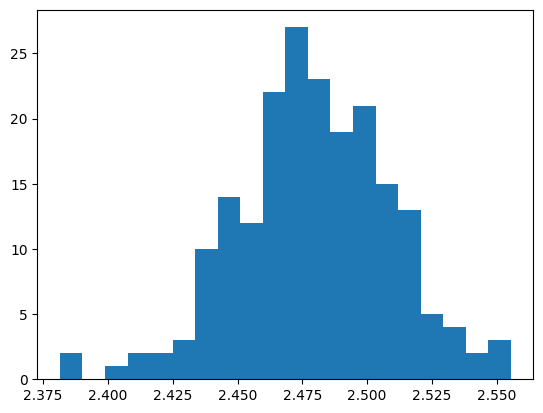

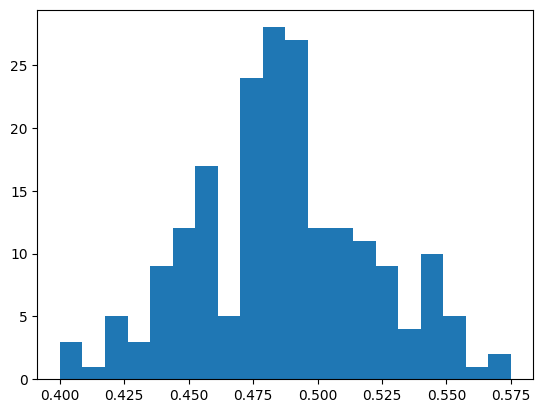

In [ ]:
#Euclidean Distance
# we can also check the variance per validation "episode" to see how much accuracy differs
# based on chosen classes as well as the support/query samples for each class
losses, accs = validate_per_episode(valid_dataloader, model, distance_fn=euclidean_distance,
                                   loss_fn=loss_fn, device=device)

plt.hist(losses, bins=20)
plt.show()

plt.hist(accs, bins=20)
plt.show()

In [ ]:
#Squared Euclidean Distance
metrics_Squared = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, valid_dataloader,
                      n_epochs=200, device=device)

Running 200 epochs at 200 steps per epoch.
Starting epoch 1... New best value found; no longer disappointed
Time taken: 46.14709281999967 seconds
	Train/val loss: 1.7044362282752992 / 1.8250702619552612
	Train/val accuracy: 0.5207249893248082 / 0.4867999851703644
	LR is now 2.4299999999999996e-06
Starting epoch 2... New best value found; no longer disappointed
Time taken: 45.17644327100061 seconds
	Train/val loss: 1.6977587270736694 / 1.8087835311889648
	Train/val accuracy: 0.5246999882161617 / 0.49239999055862427
	LR is now 7.289999999999998e-07
Starting epoch 3... EarlyStopping disappointment increased to 1
Time taken: 45.109706142000505 seconds
	Train/val loss: 1.7012334197759629 / 1.8091704845428467
	Train/val accuracy: 0.5193249876797199 / 0.4932499825954437
	LR is now 7.289999999999998e-07
Starting epoch 4... EarlyStopping disappointment increased to 2
Time taken: 45.10683903300014 seconds
	Train/val loss: 1.7095090007781983 / 1.8169459104537964
	Train/val accuracy: 0.51839998841

In [ ]:
#Squared Euclidean Distance
validate(valid_dataloader, model, distance_fn=squared_euclidean_distance,
         loss_fn=loss_fn, device=device)

(tensor(1.8138, device='cuda:0'), tensor(0.4905, device='cuda:0'))

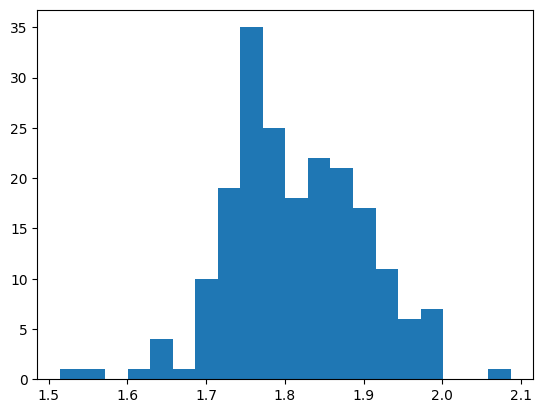

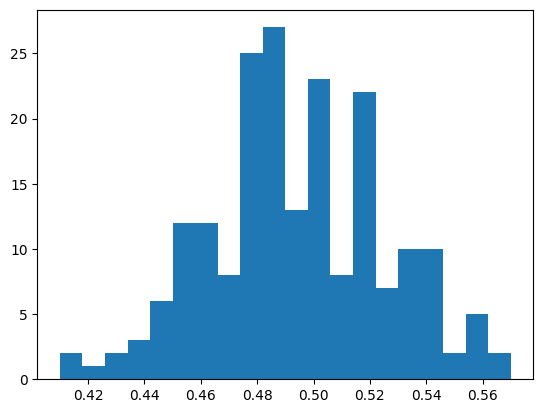

In [ ]:
#Squared Euclidean Distance
losses, accs = validate_per_episode(valid_dataloader, model, distance_fn=squared_euclidean_distance,
                                   loss_fn=loss_fn, device=device)

plt.hist(losses, bins=20)
plt.show()

plt.hist(accs, bins=20)
plt.show()